**MULTIDOCUMENT TEXT SUMMARIZATION**

*Setting google collab*

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# untuk mount gdrive
!pip install -U -q PyDrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

# untuk kasih akses ke gdrive
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**READ DATASET**

In [4]:
import pandas as pd 

data = pd.read_excel('drive/My Drive/KULIAH/skripsi/raw/dataset_pakar.xlsx')

**PREPROCESSING**

*a. Text Combining*

In [5]:
for i in range(len(data)):
  data['combined_news'] = data[['Portal Kompas.com', 'Portal CNN']].apply(lambda x: ' '.join(x), axis=1)

*c. Sentence tokenizing (Teks di pisah menjadi kalimat-kalimat)*

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
from nltk.tokenize import sent_tokenize
import numpy as np

news = []
tokenized = []
for index, row in data.iterrows():
  news.append(data['combined_news'][index])
  tokenized.append(sent_tokenize(news[index]))

np.array(tokenized, dtype="O")
data['tokenized'] = pd.DataFrame({"a": tokenized})

*b. Stop words removal (Menghapus kata tidak penting dari kamus sastrawi)*



In [8]:
!pip install Sastrawi

     |████████████████████████████████| 215kB 18.0MB/s 


In [9]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
 
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

filtered = []
for i in range(len(data)):
  temp = []
  for j in range(len(data['tokenized'][i])):
    temp.append(stopword.remove(data['tokenized'][i][j]))
  filtered.append(temp)

data['filtered'] = pd.DataFrame({"b": filtered})

*d. Stemming (Menghilangkan imbuhan)*

In [10]:
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# factory = StemmerFactory()
# stemmer = factory.create_stemmer()

# stemmed = []
# for i in range(len(data)):
#   temp = []
#   for j in range(len(data['filtered'][i])):
#     temp.append(stemmer.stem(data['filtered'][i][j]))
#   stemmed.append(temp)
#   temp = []

# data['stemmed'] = pd.DataFrame({"b": stemmed})

In [11]:
# import pickle
# pickle.dump(stemmed, open("drive/My Drive/KULIAH/skripsi/test/stemmed/stemmed_OHE_lokal.p", "wb"))

In [12]:
import pickle
data['stemmed'] = pickle.load(open("drive/My Drive/KULIAH/skripsi/test/stemmed/stemmed_OHE_lokal.p", "rb" ))

*e. Word tokenize per sentence (Kalimat di token)*

In [13]:
word_tokenize = []
for i in range(len(data)):
  temp2 = []
  for j in range(len(data['stemmed'][i])):
    temp2.append(data['stemmed'][i][j].split(" "))
  word_tokenize.append(temp2)
  temp2 = []

data['word_tokenized'] = pd.DataFrame({"b": word_tokenize})

**PROSES**

***1. TextRank***

In [14]:
all_words_per_news = []
for i in range(len(data)):
  temp = []
  for j in range(len(data['word_tokenized'][i])):
    temp = np.concatenate(data['word_tokenized'][i])
  all_words_per_news.append(temp)

*a. Create similarity matrix*

In [15]:
def build_similarity_matrix(all_words_per_news, sentences):
  S = np.ones((len(sentences), len(sentences)))
  
  for idx1 in range(len(sentences)):
    for idx2 in range(len(sentences)):
      if idx1 == idx2:
        continue
      S[idx1][idx2] = sentence_similarity(all_words_per_news, sentences[idx1], sentences[idx2])

  for idx in range(len(S)):
    S[idx] /= S[idx].sum()
    
  return S

*b. Sentence similarity*

In [16]:
def sentence_similarity(all_words_per_news, sentence1, sentence2):
  all_words = list(set(all_words_per_news))

  vector1 = [0] * len(all_words)
  vector2 = [0] * len(all_words)

  for word in sentence1:
    vector1[all_words.index(word)] += 1
  for word in sentence2:
    vector2[all_words.index(word)] += 1

  nilaixy = 0
  nilaix = 0
  nilaiy = 0
  i = 0
  while i < len(all_words):
    nilaixy += vector1[i] * vector2[i]
    nilaix += vector1[i]**2 
    nilaiy += vector2[i]**2
    i = i+1
  nilai = nilaixy / ((nilaix**(1.0/2))*(nilaiy**(1.0/2)))
  return nilai

In [17]:
# sentence_similarity_martix_OHE = []
# for i in range(len(data)):
#   sentence_similarity_martix_OHE.append(build_similarity_matrix(all_words_per_news[i], data['word_tokenized'][i]))

# data['matrix_OHE'] = pd.DataFrame({"b": sentence_similarity_martix_OHE})

In [18]:
import pickle
# pickle.dump(sentence_similarity_martix_OHE, open("drive/My Drive/KULIAH/skripsi/test/sentence_similarity_martix_OHE_lokal.p", "wb"))

sentence_similarity_martix_OHE = pickle.load(open("drive/My Drive/KULIAH/skripsi/test/sentence_similarity_martix_OHE_lokal.p", "rb"))
data['matrix_OHE'] = pd.DataFrame({"b": sentence_similarity_martix_OHE})

*c. PageRank Algorithm*

In [19]:
import networkx as nx

sentence_ranks_OHE = []
nx_graph = []
for i in range(len(data)):
  nx_graph.append(nx.from_numpy_array(data['matrix_OHE'][i]))
  sentence_ranks_OHE.append(nx.pagerank(nx_graph[i]))
data['textrank_score_per_sentence_OHE'] = pd.DataFrame({"b": sentence_ranks_OHE})

In [20]:
# def pagerank(matrix, eps=0.0001, d=0.85):
#   # Input = matrix hasil normalisasi
#   # nilai d bisa berada pada angka 0-1 tapi biasanya 0.85
#   # eps = 0,0001 karena agar bisa melakukan iterasi selanjutnya, selisih value dengan value sebelumnya harus lebih kecil dari threshold yaitu 0,0001 (kalau tidak iterasi akan terus dilanjutkan)
#   score = np.ones(len(matrix)) / len(matrix)
#   while True:
#       new_score = np.ones(len(matrix)) * (1 - d) / len(matrix) + d * matrix.T.dot(score)
#       # menghitung selisih
#       delta = abs(new_score - score).sum()
#       if delta <= eps:
#           return new_score
#       score = new_score

*d. TextRank result*

In [21]:
ranked_sentence_OHE = []
for i in range(len(data)):
  ranked_sentence_OHE.append(sorted(((data['textrank_score_per_sentence_OHE'][i][j], s, j) for j,s in enumerate(data['tokenized'][i])), reverse=True))

data['ranked_sentence_OHE'] = pd.DataFrame({"b": ranked_sentence_OHE})
print("OHE Indexes of top ranked_sentence order are ", data['ranked_sentence_OHE'])

OHE Indexes of top ranked_sentence order are  0     [(0.0410187706375472, Tim Disaster Victim Iden...
1     [(0.0409987916046015, Trump sebelumnya memilik...
2     [(0.03638611906759956, "Kami mengimbau kepada ...
3     [(0.025229755246589085, "Saya ingin menyampaik...
4     [(0.03303191510710039, Kebakaran yang terjadi ...
5     [(0.07909411881848065, Maskapai Sriwijaya Air ...
6     [(0.05672989725305112, “Benar diduga telah ter...
7     [(0.05849163296782357, Hingga saat ini, pihakn...
8     [(0.043147885108219396, "Saya menyampaikan per...
9     [(0.0345532957704281, "Memang ada pengamanan a...
10    [(0.0408274708557776, Hal tersebut dikarenakan...
11    [(0.040049105335988204, Selebritas Paris Hilto...
12    [(0.03742404549480267, Warner Bros untuk semen...
13    [(0.0619210461762923, Presiden Jokowi bertolak...
14    [(0.023627922176826053, Sebab, saat ditemukan ...
15    [(0.039305300348030855, Facebook melarang peng...
16    [(0.03389016178513427, Ashanty mengungkapkan, ...
17

*e. Compression ratio (sistem)*

In [22]:
def compression(ratio):
  compression_result = []

  for i in range(len(data)):
    temp = []
    for j in range(round(len(data['ranked_sentence_OHE'][i])*ratio)):
      temp.append(data['ranked_sentence_OHE'][i][j][2])
    compression_result.append(temp)
    temp = []

  return compression_result

1. Compression ratio 20%

In [23]:
result_OHE = compression(0.8)
data['OHE_compression_20'] = pd.DataFrame({"b": result_OHE})

2. Compression ratio 25%

In [24]:
result_OHE = compression(0.75)
data['OHE_compression_25'] = pd.DataFrame({"b": result_OHE})

3. Compression ratio 30%

In [25]:
result_OHE = compression(0.7)
data['OHE_compression_30'] = pd.DataFrame({"b": result_OHE})

4. Compression ratio 35%

In [26]:
result_OHE = compression(0.65)
data['OHE_compression_35'] = pd.DataFrame({"b": result_OHE})

5. Compression ratio 40%

In [27]:
result_OHE = compression(0.6)
data['OHE_compression_40'] = pd.DataFrame({"b": result_OHE})

6. Compression ratio 45%

In [28]:
result_OHE = compression(0.55)
data['OHE_compression_45'] = pd.DataFrame({"b": result_OHE})

7. Compression ratio 50%

In [29]:
result_OHE = compression(0.5)
data['OHE_compression_50'] = pd.DataFrame({"b": result_OHE})

8. Compression ratio 55%

In [30]:
result_OHE = compression(0.45)
data['OHE_compression_55'] = pd.DataFrame({"b": result_OHE})

9. Compression ratio 60%

In [31]:
result_OHE = compression(0.4)
data['OHE_compression_60'] = pd.DataFrame({"b": result_OHE})

10. Compression ratio 65%

In [32]:
result_OHE = compression(0.35)
data['OHE_compression_65'] = pd.DataFrame({"b": result_OHE})

11. Compression ratio 70%

In [33]:
result_OHE = compression(0.3)
data['OHE_compression_70'] = pd.DataFrame({"b": result_OHE})

12. Compression ratio 75%

In [34]:
result_OHE = compression(0.25)
data['OHE_compression_75'] = pd.DataFrame({"b": result_OHE})

13. Compression ratio 80%

In [35]:
result_OHE = compression(0.2)
data['OHE_compression_80'] = pd.DataFrame({"b": result_OHE})

*f. Summary Sistem*

In [36]:
def printSummary(ratio):
  summary = []

  for i in range(len(data)):
    temp = []
    if ratio == 20:
      for j in range(len(data['OHE_compression_20'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_20'][i][j]])
      summary.append(temp)
    elif ratio == 25:
      for j in range(len(data['OHE_compression_25'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_25'][i][j]])
      summary.append(temp)
    elif ratio == 30:
      for j in range(len(data['OHE_compression_30'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_30'][i][j]])
      summary.append(temp)
    elif ratio == 35:
      for j in range(len(data['OHE_compression_35'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_35'][i][j]])
      summary.append(temp)
    elif ratio == 40:
      for j in range(len(data['OHE_compression_40'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_40'][i][j]])
      summary.append(temp)
    elif ratio == 45:
      for j in range(len(data['OHE_compression_45'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_45'][i][j]])
      summary.append(temp)
    elif ratio == 50:
      for j in range(len(data['OHE_compression_50'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_50'][i][j]])
      summary.append(temp)
    elif ratio == 55:
      for j in range(len(data['OHE_compression_55'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_55'][i][j]])
      summary.append(temp)
    elif ratio == 60:
      for j in range(len(data['OHE_compression_60'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_60'][i][j]])
      summary.append(temp)
    elif ratio == 65:
      for j in range(len(data['OHE_compression_65'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_65'][i][j]])
      summary.append(temp)
    elif ratio == 70:
      for j in range(len(data['OHE_compression_70'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_70'][i][j]])
      summary.append(temp)
    elif ratio == 75:
      for j in range(len(data['OHE_compression_75'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_75'][i][j]])
      summary.append(temp)
    elif ratio == 80:
      for j in range(len(data['OHE_compression_80'][i])):
        temp.append(data['tokenized'][i][data['OHE_compression_80'][i][j]])
      summary.append(temp)
  return summary

In [37]:
result_20 = printSummary(20)
data['OHE_summary_20'] = pd.DataFrame({"b": result_20})

result_25 = printSummary(25)
data['OHE_summary_25'] = pd.DataFrame({"b": result_25})

result_30 = printSummary(30)
data['OHE_summary_30'] = pd.DataFrame({"b": result_30})

result_35 = printSummary(35)
data['OHE_summary_35'] = pd.DataFrame({"b": result_35})

result_40 = printSummary(40)
data['OHE_summary_40'] = pd.DataFrame({"b": result_40})

result_45 = printSummary(45)
data['OHE_summary_45'] = pd.DataFrame({"b": result_45})

result_50 = printSummary(50)
data['OHE_summary_50'] = pd.DataFrame({"b": result_50})

result_55 = printSummary(55)
data['OHE_summary_55'] = pd.DataFrame({"b": result_55})

result_60 = printSummary(60)
data['OHE_summary_60'] = pd.DataFrame({"b": result_60})

result_65 = printSummary(65)
data['OHE_summary_65'] = pd.DataFrame({"b": result_65})

result_70 = printSummary(70)
data['OHE_summary_70'] = pd.DataFrame({"b": result_70})

result_75 = printSummary(75)
data['OHE_summary_75'] = pd.DataFrame({"b": result_75})

result_80 = printSummary(80)
data['OHE_summary_80'] = pd.DataFrame({"b": result_80})

**EVALUASI**

In [38]:
ringkasan_manual = []
for i in range(len(data)):
  ringkasan_manual.append(data['Index Ringkasan Manual'][i].split(', '))

In [39]:
def compression_manual(ratio):
  int_ringkasan_manual = []
  for i in range(len(data)):
    int_ringkasan_manual.append([int(i) for i in ringkasan_manual[i][0:round(len(ringkasan_manual[i])*ratio)]])
  
  return int_ringkasan_manual

In [40]:
def irisan_manual_dan_sistem(ringkasan_manual, ratio):
  irisan = []
  if ratio == 20:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_20'][i])))
  elif ratio == 25:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_25'][i])))
  elif ratio == 30:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_30'][i])))
  elif ratio == 35:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_35'][i])))
  elif ratio == 40:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_40'][i])))
  elif ratio == 45:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_45'][i])))
  elif ratio == 50:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_50'][i])))
  elif ratio == 55:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_55'][i])))
  elif ratio == 60:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_60'][i])))
  elif ratio == 65:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_65'][i])))
  elif ratio == 70:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_70'][i])))
  elif ratio == 75:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_75'][i])))
  elif ratio == 80:
    for i in range(len(data)):
      irisan.append(list(set(ringkasan_manual[i]) & set(data['OHE_compression_80'][i])))
  return irisan

In [41]:
def precision(irisan, ratio):
  precision = []
  if ratio == 20:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_20'][i])))
  elif ratio == 25:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_25'][i])))
  elif ratio == 30:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_30'][i])))
  elif ratio == 35:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_35'][i])))
  elif ratio == 40:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_40'][i])))
  elif ratio == 45:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_45'][i])))
  elif ratio == 50:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_50'][i])))
  elif ratio == 55:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_55'][i])))
  elif ratio == 60:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_60'][i])))
  elif ratio == 65:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_65'][i])))
  elif ratio == 70:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_70'][i])))
  elif ratio == 75:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_75'][i])))
  elif ratio == 80:
    for i in range(len(data)):
      precision.append(len(irisan[i])/(len(data['OHE_compression_80'][i])))
  return precision

In [42]:
def recall(irisan, manual):
  recall = []

  for i in range(len(data)):
    recall.append(len(irisan[i])/(len(manual[i])))
  return recall

In [43]:
def fmeassure (recall, precision):
  fmeassure = []

  for i in range(len(data)):
    fmeassure.append((2 * recall[i] * precision[i]) / (recall[i] + precision[i]))
  return fmeassure

1. Compression ratio 20%

In [44]:
int_ringkasan_manual = compression_manual(0.8)

# manual n mesin
OHE_irisan_manual_dan_sistem_20 = irisan_manual_dan_sistem(int_ringkasan_manual, 20)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [45]:
OHE_precision_score_20 = precision(OHE_irisan_manual_dan_sistem_20, 20)
data['OHE_precision_score_20'] = pd.DataFrame({"b": OHE_precision_score_20})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [46]:
OHE_recall_score_20 = recall(OHE_irisan_manual_dan_sistem_20, int_ringkasan_manual)
data['OHE_recall_score_20'] = pd.DataFrame({"b": OHE_recall_score_20})

*c. F-meassure*

In [47]:
OHE_fmeassure_score_20 = fmeassure(data['OHE_recall_score_20'], data['OHE_precision_score_20'])
data['OHE_fmeassure_score_20'] = pd.DataFrame({"b": OHE_fmeassure_score_20})

*d. Average Precision, Recall, F-meassure*

In [48]:
OHE_precision_avg_score_20 = sum(data['OHE_precision_score_20']) / len(data['OHE_precision_score_20'])
OHE_recall_avg_score_20 = sum(data['OHE_recall_score_20']) / len(data['OHE_recall_score_20'])
OHE_fmeassure_avg_score_20 = sum(data['OHE_fmeassure_score_20']) / len(data['OHE_fmeassure_score_20'])

In [49]:
print(OHE_precision_avg_score_20)
print(OHE_recall_avg_score_20)
print(OHE_fmeassure_avg_score_20)

0.7833498531619713
0.7891442730440584
0.7860469356666634


2. Compression ratio 25%

In [50]:
int_ringkasan_manual = compression_manual(0.75)

# manual n mesin
OHE_irisan_manual_dan_sistem_25 = irisan_manual_dan_sistem(int_ringkasan_manual, 25)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [51]:
OHE_precision_score_25 = precision(OHE_irisan_manual_dan_sistem_25, 25)
data['OHE_precision_score_25'] = pd.DataFrame({"b": OHE_precision_score_25})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [52]:
OHE_recall_score_25 = recall(OHE_irisan_manual_dan_sistem_25, int_ringkasan_manual)
data['OHE_recall_score_25'] = pd.DataFrame({"b": OHE_recall_score_25})

*c. F-meassure*

In [53]:
OHE_fmeassure_score_25 = fmeassure(data['OHE_recall_score_25'], data['OHE_precision_score_25'])
data['OHE_fmeassure_score_25'] = pd.DataFrame({"b": OHE_fmeassure_score_25})

*d. Average Precision, Recall, F-meassure*

In [54]:
OHE_precision_avg_score_25 = sum(data['OHE_precision_score_25']) / len(data['OHE_precision_score_25'])
OHE_recall_avg_score_25 = sum(data['OHE_recall_score_25']) / len(data['OHE_recall_score_25'])
OHE_fmeassure_avg_score_25 = sum(data['OHE_fmeassure_score_25']) / len(data['OHE_fmeassure_score_25'])

In [55]:
print(OHE_precision_avg_score_25)
print(OHE_recall_avg_score_25)
print(OHE_fmeassure_avg_score_25)

0.7321061474086268
0.7360431076889318
0.7339254489366023


3. Compression ratio 30%

In [56]:
int_ringkasan_manual = compression_manual(0.7)

# manual n mesin
OHE_irisan_manual_dan_sistem_30 = irisan_manual_dan_sistem(int_ringkasan_manual, 30)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [57]:
OHE_precision_score_30 = precision(OHE_irisan_manual_dan_sistem_30, 30)
data['OHE_precision_score_30'] = pd.DataFrame({"b": OHE_precision_score_30})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [58]:
OHE_recall_score_30 = recall(OHE_irisan_manual_dan_sistem_30, int_ringkasan_manual)
data['OHE_recall_score_30'] = pd.DataFrame({"b": OHE_recall_score_30})

*c. F-meassure*

In [59]:
OHE_fmeassure_score_30 = fmeassure(data['OHE_recall_score_30'], data['OHE_precision_score_30'])
data['OHE_fmeassure_score_30'] = pd.DataFrame({"b": OHE_fmeassure_score_30})

*d. Average Precision, Recall, F-meassure*

In [60]:
OHE_precision_avg_score_30 = sum(data['OHE_precision_score_30']) / len(data['OHE_precision_score_30'])
OHE_recall_avg_score_30 = sum(data['OHE_recall_score_30']) / len(data['OHE_recall_score_30'])
OHE_fmeassure_avg_score_30 = sum(data['OHE_fmeassure_score_30']) / len(data['OHE_fmeassure_score_30'])

In [61]:
print(OHE_precision_avg_score_30)
print(OHE_recall_avg_score_30)
print(OHE_fmeassure_avg_score_30)

0.693008782094512
0.6961965545935226
0.6944714582163733


4. Compression ratio 35%

In [62]:
int_ringkasan_manual = compression_manual(0.65)

# manual n mesin
OHE_irisan_manual_dan_sistem_35 = irisan_manual_dan_sistem(int_ringkasan_manual, 35)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [63]:
OHE_precision_score_35 = precision(OHE_irisan_manual_dan_sistem_35, 35)
data['OHE_precision_score_35'] = pd.DataFrame({"b": OHE_precision_score_35})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [64]:
OHE_recall_score_35 = recall(OHE_irisan_manual_dan_sistem_35, int_ringkasan_manual)
data['OHE_recall_score_35'] = pd.DataFrame({"b": OHE_recall_score_35})

*c. F-meassure*

In [65]:
OHE_fmeassure_score_35 = fmeassure(data['OHE_recall_score_35'], data['OHE_precision_score_35'])
data['OHE_fmeassure_score_35'] = pd.DataFrame({"b": OHE_fmeassure_score_35})

*d. Average Precision, Recall, F-meassure*

In [66]:
OHE_precision_avg_score_35 = sum(data['OHE_precision_score_35']) / len(data['OHE_precision_score_35'])
OHE_recall_avg_score_35 = sum(data['OHE_recall_score_35']) / len(data['OHE_recall_score_35'])
OHE_fmeassure_avg_score_35 = sum(data['OHE_fmeassure_score_35']) / len(data['OHE_fmeassure_score_35'])

In [67]:
print(OHE_precision_avg_score_35)
print(OHE_recall_avg_score_35)
print(OHE_fmeassure_avg_score_35)

0.6600021083407704
0.6623613197499963
0.6610525631731746


5. Compression ratio 40%

In [68]:
# untuk compression 40%
int_ringkasan_manual = compression_manual(0.6)

# manual n mesin
OHE_irisan_manual_dan_sistem_40 = irisan_manual_dan_sistem(int_ringkasan_manual, 40)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [69]:
OHE_precision_score_40 = precision(OHE_irisan_manual_dan_sistem_40, 40)
data['OHE_precision_score_40'] = pd.DataFrame({"b": OHE_precision_score_40})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [70]:
OHE_recall_score_40 = recall(OHE_irisan_manual_dan_sistem_40, int_ringkasan_manual)
data['OHE_recall_score_40'] = pd.DataFrame({"b": OHE_recall_score_40})

*c. F-meassure*

In [71]:
OHE_fmeassure_score_40 = fmeassure(data['OHE_recall_score_40'], data['OHE_precision_score_40'])
data['OHE_fmeassure_score_40'] = pd.DataFrame({"b": OHE_fmeassure_score_40})

*d. Average Precision, Recall, F-meassure*

In [72]:
OHE_precision_avg_score_40 = sum(data['OHE_precision_score_40']) / len(data['OHE_precision_score_40'])
OHE_recall_avg_score_40 = sum(data['OHE_recall_score_40']) / len(data['OHE_recall_score_40'])
OHE_fmeassure_avg_score_40 = sum(data['OHE_fmeassure_score_40']) / len(data['OHE_fmeassure_score_40'])

In [73]:
print(OHE_precision_avg_score_40)
print(OHE_recall_avg_score_40)
print(OHE_fmeassure_avg_score_40)

0.6241579704916039
0.6284637987984123
0.626171623273933


6. Compression ratio 45%

In [74]:
int_ringkasan_manual = compression_manual(0.55)

# manual n mesin
OHE_irisan_manual_dan_sistem_45 = irisan_manual_dan_sistem(int_ringkasan_manual, 45)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [75]:
OHE_precision_score_45 = precision(OHE_irisan_manual_dan_sistem_45, 45)
data['OHE_precision_score_45'] = pd.DataFrame({"b": OHE_precision_score_45})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [76]:
OHE_recall_score_45 = recall(OHE_irisan_manual_dan_sistem_45, int_ringkasan_manual)
data['OHE_recall_score_45'] = pd.DataFrame({"b": OHE_recall_score_45})

*c. F-meassure*

In [77]:
OHE_fmeassure_score_45 = fmeassure(data['OHE_recall_score_45'], data['OHE_precision_score_45'])
data['OHE_fmeassure_score_45'] = pd.DataFrame({"b": OHE_fmeassure_score_45})

*d. Average Precision, Recall, F-meassure*

In [78]:
OHE_precision_avg_score_45 = sum(data['OHE_precision_score_45']) / len(data['OHE_precision_score_45'])
OHE_recall_avg_score_45 = sum(data['OHE_recall_score_45']) / len(data['OHE_recall_score_45'])
OHE_fmeassure_avg_score_45 = sum(data['OHE_fmeassure_score_45']) / len(data['OHE_fmeassure_score_45'])

In [79]:
print(OHE_precision_avg_score_45)
print(OHE_recall_avg_score_45)
print(OHE_fmeassure_avg_score_45)

0.5794806029480054
0.5835484391521487
0.581364575979289


7. Compression ratio 50%

In [80]:
int_ringkasan_manual = compression_manual(0.5)

# manual n mesin
OHE_irisan_manual_dan_sistem_50 = irisan_manual_dan_sistem(int_ringkasan_manual, 50)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [81]:
OHE_precision_score_50 = precision(OHE_irisan_manual_dan_sistem_50, 50)
data['OHE_precision_score_50'] = pd.DataFrame({"b": OHE_precision_score_50})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [82]:
OHE_recall_score_50 = recall(OHE_irisan_manual_dan_sistem_50, int_ringkasan_manual)
data['OHE_recall_score_50'] = pd.DataFrame({"b": OHE_recall_score_50})

*c. F-meassure*

In [83]:
OHE_fmeassure_score_50 = fmeassure(data['OHE_recall_score_50'], data['OHE_precision_score_50'])
data['OHE_fmeassure_score_50'] = pd.DataFrame({"b": OHE_fmeassure_score_50})

*d. Average Precision, Recall, F-meassure*

In [84]:
OHE_precision_avg_score_50 = sum(data['OHE_precision_score_50']) / len(data['OHE_precision_score_50'])
OHE_recall_avg_score_50 = sum(data['OHE_recall_score_50']) / len(data['OHE_recall_score_50'])
OHE_fmeassure_avg_score_50 = sum(data['OHE_fmeassure_score_50']) / len(data['OHE_fmeassure_score_50'])

In [85]:
print(OHE_precision_avg_score_50)
print(OHE_recall_avg_score_50)
print(OHE_fmeassure_avg_score_50)

0.5558497404391873
0.5595507385151854
0.5575940745895516


8. Compression ratio 55%

In [86]:
int_ringkasan_manual = compression_manual(0.45)

# manual n mesin
OHE_irisan_manual_dan_sistem_55 = irisan_manual_dan_sistem(int_ringkasan_manual, 55)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [87]:
OHE_precision_score_55 = precision(OHE_irisan_manual_dan_sistem_55, 55)
data['OHE_precision_score_55'] = pd.DataFrame({"b": OHE_precision_score_55})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [88]:
OHE_recall_score_55 = recall(OHE_irisan_manual_dan_sistem_55, int_ringkasan_manual)
data['OHE_recall_score_55'] = pd.DataFrame({"b": OHE_recall_score_55})

*c. F-meassure*

In [89]:
OHE_fmeassure_score_55 = fmeassure(data['OHE_recall_score_55'], data['OHE_precision_score_55'])
data['OHE_fmeassure_score_55'] = pd.DataFrame({"b": OHE_fmeassure_score_55})

*d. Average Precision, Recall, F-meassure*

In [90]:
OHE_precision_avg_score_55 = sum(data['OHE_precision_score_55']) / len(data['OHE_precision_score_55'])
OHE_recall_avg_score_55 = sum(data['OHE_recall_score_55']) / len(data['OHE_recall_score_55'])
OHE_fmeassure_avg_score_55 = sum(data['OHE_fmeassure_score_55']) / len(data['OHE_fmeassure_score_55'])

In [91]:
print(OHE_precision_avg_score_55)
print(OHE_recall_avg_score_55)
print(OHE_fmeassure_avg_score_55)

0.5226456468368234
0.5247882157744691
0.5236045017441034


9. Compression ratio 60%

In [92]:
int_ringkasan_manual = compression_manual(0.40)

# manual n mesin
OHE_irisan_manual_dan_sistem_60 = irisan_manual_dan_sistem(int_ringkasan_manual, 60)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [93]:
OHE_precision_score_60 = precision(OHE_irisan_manual_dan_sistem_60, 60)
data['OHE_precision_score_60'] = pd.DataFrame({"b": OHE_precision_score_60})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [94]:
OHE_recall_score_60 = recall(OHE_irisan_manual_dan_sistem_60, int_ringkasan_manual)
data['OHE_recall_score_60'] = pd.DataFrame({"b": OHE_recall_score_60})

*c. F-meassure*

In [95]:
OHE_fmeassure_score_60 = fmeassure(data['OHE_recall_score_60'], data['OHE_precision_score_60'])
data['OHE_fmeassure_score_60'] = pd.DataFrame({"b": OHE_fmeassure_score_60})

*d. Average Precision, Recall, F-meassure*

In [96]:
OHE_precision_avg_score_60 = sum(data['OHE_precision_score_60']) / len(data['OHE_precision_score_60'])
OHE_recall_avg_score_60 = sum(data['OHE_recall_score_60']) / len(data['OHE_recall_score_60'])
OHE_fmeassure_avg_score_60 = sum(data['OHE_fmeassure_score_60']) / len(data['OHE_fmeassure_score_60'])

In [97]:
print(OHE_precision_avg_score_60)
print(OHE_recall_avg_score_60)
print(OHE_fmeassure_avg_score_60)

0.49573703221729554
0.497773421753685
0.49662396329388175


10. Compression ratio 65%

In [98]:
int_ringkasan_manual = compression_manual(0.35)

# manual n mesin
OHE_irisan_manual_dan_sistem_65 = irisan_manual_dan_sistem(int_ringkasan_manual, 65)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [99]:
OHE_precision_score_65 = precision(OHE_irisan_manual_dan_sistem_65, 65)
data['OHE_precision_score_65'] = pd.DataFrame({"b": OHE_precision_score_65})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [100]:
OHE_recall_score_65 = recall(OHE_irisan_manual_dan_sistem_65, int_ringkasan_manual)
data['OHE_recall_score_65'] = pd.DataFrame({"b": OHE_recall_score_65})

*c. F-meassure*

In [101]:
OHE_fmeassure_score_65 = fmeassure(data['OHE_recall_score_65'], data['OHE_precision_score_65'])
data['OHE_fmeassure_score_65'] = pd.DataFrame({"b": OHE_fmeassure_score_65})

*d. Average Precision, Recall, F-meassure*

In [102]:
OHE_precision_avg_score_65 = sum(data['OHE_precision_score_65']) / len(data['OHE_precision_score_65'])
OHE_recall_avg_score_65 = sum(data['OHE_recall_score_65']) / len(data['OHE_recall_score_65'])
OHE_fmeassure_avg_score_65 = sum(data['OHE_fmeassure_score_65']) / len(data['OHE_fmeassure_score_65'])

In [103]:
print(OHE_precision_avg_score_65)
print(OHE_recall_avg_score_65)
print(OHE_fmeassure_avg_score_65)

0.4702891735457525
0.474821682946683
0.47236526390202854


11. Compression ratio 70%

In [104]:
int_ringkasan_manual = compression_manual(0.30)

# manual n mesin
OHE_irisan_manual_dan_sistem_70 = irisan_manual_dan_sistem(int_ringkasan_manual, 70)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [105]:
OHE_precision_score_70 = precision(OHE_irisan_manual_dan_sistem_70, 70)
data['OHE_precision_score_70'] = pd.DataFrame({"b": OHE_precision_score_70})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [106]:
OHE_recall_score_70 = recall(OHE_irisan_manual_dan_sistem_70, int_ringkasan_manual)
data['OHE_recall_score_70'] = pd.DataFrame({"b": OHE_recall_score_70})

*c. F-meassure*

In [107]:
OHE_fmeassure_score_70 = fmeassure(data['OHE_recall_score_70'], data['OHE_precision_score_70'])
data['OHE_fmeassure_score_70'] = pd.DataFrame({"b": OHE_fmeassure_score_70})

*d. Average Precision, Recall, F-meassure*

In [108]:
OHE_precision_avg_score_70 = sum(data['OHE_precision_score_70']) / len(data['OHE_precision_score_70'])
OHE_recall_avg_score_70 = sum(data['OHE_recall_score_70']) / len(data['OHE_recall_score_70'])
OHE_fmeassure_avg_score_70 = sum(data['OHE_fmeassure_score_70']) / len(data['OHE_fmeassure_score_70'])

In [109]:
print(OHE_precision_avg_score_70)
print(OHE_recall_avg_score_70)
print(OHE_fmeassure_avg_score_70)

0.4270187682687682
0.43050722425722415
0.4285686024501814


12. Compression ratio 75%

In [110]:
int_ringkasan_manual = compression_manual(0.25)

# manual n mesin
OHE_irisan_manual_dan_sistem_75 = irisan_manual_dan_sistem(int_ringkasan_manual, 75)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [111]:
OHE_precision_score_75 = precision(OHE_irisan_manual_dan_sistem_75, 75)
data['OHE_precision_score_75'] = pd.DataFrame({"b": OHE_precision_score_75})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [112]:
OHE_recall_score_75 = recall(OHE_irisan_manual_dan_sistem_75, int_ringkasan_manual)
data['OHE_recall_score_75'] = pd.DataFrame({"b": OHE_recall_score_75})

*c. F-meassure*

In [113]:
OHE_fmeassure_score_75 = fmeassure(data['OHE_recall_score_75'], data['OHE_precision_score_75'])
data['OHE_fmeassure_score_75'] = pd.DataFrame({"b": OHE_fmeassure_score_75})
data['OHE_fmeassure_score_75'] = data['OHE_fmeassure_score_75'].replace(np.nan, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


*d. Average Precision, Recall, F-meassure*

In [114]:
OHE_precision_avg_score_75 = sum(data['OHE_precision_score_75']) / len(data['OHE_precision_score_75'])
OHE_recall_avg_score_75 = sum(data['OHE_recall_score_75']) / len(data['OHE_recall_score_75'])
OHE_fmeassure_avg_score_75 = sum(data['OHE_fmeassure_score_75']) / len(data['OHE_fmeassure_score_75'])

In [115]:
print(OHE_precision_avg_score_75)
print(OHE_recall_avg_score_75)
print(OHE_fmeassure_avg_score_75)

0.3945586358086358
0.3956787656787657
0.3950282125282125


13. Compression ratio 80%

In [116]:
int_ringkasan_manual = compression_manual(0.20)

# manual n mesin
OHE_irisan_manual_dan_sistem_80 = irisan_manual_dan_sistem(int_ringkasan_manual, 80)

*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [117]:
OHE_precision_score_80 = precision(OHE_irisan_manual_dan_sistem_80, 80)
data['OHE_precision_score_80'] = pd.DataFrame({"b": OHE_precision_score_80})

*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [118]:
OHE_recall_score_80 = recall(OHE_irisan_manual_dan_sistem_80, int_ringkasan_manual)
data['OHE_recall_score_80'] = pd.DataFrame({"b": OHE_recall_score_80})

*c. F-meassure*

In [119]:
OHE_fmeassure_score_80 = fmeassure(data['OHE_recall_score_80'], data['OHE_precision_score_80'])
data['OHE_fmeassure_score_80'] = pd.DataFrame({"b": OHE_fmeassure_score_80})
data['OHE_fmeassure_score_80'] = data['OHE_fmeassure_score_80'].replace(np.nan, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


*d. Average Precision, Recall, F-meassure*

In [120]:
OHE_precision_avg_score_80 = sum(data['OHE_precision_score_80']) / len(data['OHE_precision_score_80'])
OHE_recall_avg_score_80 = sum(data['OHE_recall_score_80']) / len(data['OHE_recall_score_80'])
OHE_fmeassure_avg_score_80 = sum(data['OHE_fmeassure_score_80']) / len(data['OHE_fmeassure_score_80'])

In [121]:
print(OHE_precision_avg_score_80)
print(OHE_recall_avg_score_80)
print(OHE_fmeassure_avg_score_80)

0.37280543530543536
0.37281084656084656
0.37276523857406213


**VISUALISASI EVALUASI**

*a. Graph*

In [122]:
from matplotlib import pyplot as plt

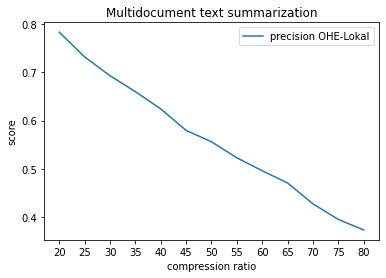

In [123]:
OHE_precision = [OHE_precision_avg_score_20, OHE_precision_avg_score_25, OHE_precision_avg_score_30, OHE_precision_avg_score_35, OHE_precision_avg_score_40, OHE_precision_avg_score_45, OHE_precision_avg_score_50, OHE_precision_avg_score_55, OHE_precision_avg_score_60, OHE_precision_avg_score_65, OHE_precision_avg_score_70, OHE_precision_avg_score_75, OHE_precision_avg_score_80]

x1 = ['20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80'] 
y1 = OHE_precision
plt.plot(x1, y1, label= "precision OHE-Lokal")

plt.xlabel('compression ratio')
plt.ylabel('score')
plt.title('Multidocument text summarization')
plt.legend()
plt.show() 


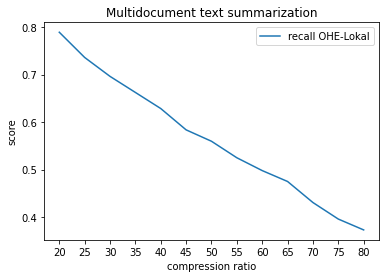

In [124]:
OHE_recall = [OHE_recall_avg_score_20, OHE_recall_avg_score_25, OHE_recall_avg_score_30, OHE_recall_avg_score_35, OHE_recall_avg_score_40, 
              OHE_recall_avg_score_45, OHE_recall_avg_score_50, OHE_recall_avg_score_55, OHE_recall_avg_score_60, OHE_recall_avg_score_65, OHE_recall_avg_score_70, OHE_recall_avg_score_75, OHE_recall_avg_score_80]

x1 = ['20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80'] 
y1 = OHE_recall
plt.plot(x1, y1, label= "recall OHE-Lokal")

plt.xlabel('compression ratio')
plt.ylabel('score')
plt.title('Multidocument text summarization')
plt.legend()
plt.show()

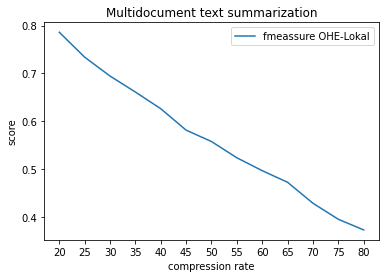

In [125]:
OHE_fmeassure = [OHE_fmeassure_avg_score_20, OHE_fmeassure_avg_score_25, OHE_fmeassure_avg_score_30, OHE_fmeassure_avg_score_35, OHE_fmeassure_avg_score_40, 
                 OHE_fmeassure_avg_score_45, OHE_fmeassure_avg_score_50, OHE_fmeassure_avg_score_55, OHE_fmeassure_avg_score_60, OHE_fmeassure_avg_score_65, OHE_fmeassure_avg_score_70, OHE_fmeassure_avg_score_75, OHE_fmeassure_avg_score_80]

x1 = ['20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80'] 
y1 = OHE_fmeassure
plt.plot(x1, y1, label= "fmeassure OHE-Lokal")

plt.xlabel('compression rate')
plt.ylabel('score')
plt.title('Multidocument text summarization')
plt.legend()
plt.show() 

**DEMO**

*a. Pemilihan topik berita*

In [149]:
judul_berita1 = input("Berita kompas = ")
berita1 = input("Isi = ")

judul_berita2 = input("Berita CNN = ")
berita2 = input("Isi = ")

Berita kompas = Sriwijaya Gratiskan Rapid Test Antigen di Sejumlah Penerbangan
Isi = Maskapai Sriwijaya Air menggratiskan rapid test antigen di sejumlah penerbangan untuk menggairahkan kembali minat masyarakat terbang dengan pesawat terbang, sekaligus memberikan kemudahan khususnya bagi penumpang. “Kami melihat langsung kondisi pandemi saat ini sudah semakin mengkhawatirkan, akan tetapi pergerakan penumpang dengan menggunakan pesawat terbang untuk berbagai keperluan masih tak terhindarkan," kata Direktur Niaga Sriwijaya Air Group Henoch Rudi Iwanudin dilansir dari Antara, Minggu (31/1/2021). Program rapid test antigen gratis tersebut ada pada beberapa rute penerbangan Sriwijaya Air dan NAM Air antara lain Jakarta-Pangkal Pinang-Jakarta, Jakarta-Tanjung Pandan-Jakarta, Pangkal Pinang-Tanjung Pandan-Pangkal Pinang, Pangkal Pinang-Palembang-Pangkal Pinang, dan Pontianak-Putussibau, sertaPontianak-Jakarta. “Lokasi pelaksanaan rapid test Antigen gratis ini tersedia di Kantor Sriwijaya Air G

*b. **Preprocessing** -> Text Combining, Sentence Tokenizing, Filtering, Stemming, Word Tokenizing*

1. Text Combining

In [150]:
news_combined = berita1 + berita2
news_combined

'Maskapai Sriwijaya Air menggratiskan rapid test antigen di sejumlah penerbangan untuk menggairahkan kembali minat masyarakat terbang dengan pesawat terbang, sekaligus memberikan kemudahan khususnya bagi penumpang. “Kami melihat langsung kondisi pandemi saat ini sudah semakin mengkhawatirkan, akan tetapi pergerakan penumpang dengan menggunakan pesawat terbang untuk berbagai keperluan masih tak terhindarkan," kata Direktur Niaga Sriwijaya Air Group Henoch Rudi Iwanudin dilansir dari Antara, Minggu (31/1/2021). Program rapid test antigen gratis tersebut ada pada beberapa rute penerbangan Sriwijaya Air dan NAM Air antara lain Jakarta-Pangkal Pinang-Jakarta, Jakarta-Tanjung Pandan-Jakarta, Pangkal Pinang-Tanjung Pandan-Pangkal Pinang, Pangkal Pinang-Palembang-Pangkal Pinang, dan Pontianak-Putussibau, sertaPontianak-Jakarta. “Lokasi pelaksanaan rapid test Antigen gratis ini tersedia di Kantor Sriwijaya Air Group Cabang Melawai, Sriwijaya Air Tower di Cengkareng, Rumah Sakit Kalbu Intan Medi

2. Sentence tokenizing

In [151]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [152]:
from nltk.tokenize import sent_tokenize
import numpy as np

tokenized = sent_tokenize(news_combined)

print(tokenized)
print("Banyak kalimat = ", len(tokenized))

['Maskapai Sriwijaya Air menggratiskan rapid test antigen di sejumlah penerbangan untuk menggairahkan kembali minat masyarakat terbang dengan pesawat terbang, sekaligus memberikan kemudahan khususnya bagi penumpang.', '“Kami melihat langsung kondisi pandemi saat ini sudah semakin mengkhawatirkan, akan tetapi pergerakan penumpang dengan menggunakan pesawat terbang untuk berbagai keperluan masih tak terhindarkan," kata Direktur Niaga Sriwijaya Air Group Henoch Rudi Iwanudin dilansir dari Antara, Minggu (31/1/2021).', 'Program rapid test antigen gratis tersebut ada pada beberapa rute penerbangan Sriwijaya Air dan NAM Air antara lain Jakarta-Pangkal Pinang-Jakarta, Jakarta-Tanjung Pandan-Jakarta, Pangkal Pinang-Tanjung Pandan-Pangkal Pinang, Pangkal Pinang-Palembang-Pangkal Pinang, dan Pontianak-Putussibau, sertaPontianak-Jakarta.', '“Lokasi pelaksanaan rapid test Antigen gratis ini tersedia di Kantor Sriwijaya Air Group Cabang Melawai, Sriwijaya Air Tower di Cengkareng, Rumah Sakit Kalbu 

3. Filtering

In [153]:
!pip install Sastrawi

In [154]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
 
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

filtered = []
for i in range(len(tokenized)):
    filtered.append(stopword.remove(tokenized[i]))

print(filtered)

['Maskapai Sriwijaya Air menggratiskan rapid test antigen sejumlah penerbangan menggairahkan minat masyarakat terbang pesawat terbang, sekaligus memberikan kemudahan khususnya penumpang.', '“Kami melihat langsung kondisi pandemi ini semakin mengkhawatirkan, tetapi pergerakan penumpang menggunakan pesawat terbang berbagai keperluan tak terhindarkan," kata Direktur Niaga Sriwijaya Air Group Henoch Rudi Iwanudin dilansir Antara, Minggu (31/1/2021).', 'Program rapid test antigen gratis tersebut pada beberapa rute penerbangan Sriwijaya Air NAM Air lain Jakarta-Pangkal Pinang-Jakarta, Jakarta-Tanjung Pandan-Jakarta, Pangkal Pinang-Tanjung Pandan-Pangkal Pinang, Pangkal Pinang-Palembang-Pangkal Pinang, Pontianak-Putussibau, sertaPontianak-Jakarta.', '“Lokasi pelaksanaan rapid test Antigen gratis tersedia Kantor Sriwijaya Air Group Cabang Melawai, Sriwijaya Air Tower Cengkareng, Rumah Sakit Kalbu Intan Medika Pangkal Pinang, Belitung Medical Center Tanjung Pandan, Klinik dr Jane Ariesta Palemb

4. Stemming

In [155]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stemmed = []
for i in range(len(filtered)):
    stemmed.append(stemmer.stem(filtered[i]))

print(stemmed)

['maskapai sriwijaya air gratis rapid test antigen jumlah terbang gairah minat masyarakat terbang pesawat terbang sekaligus beri mudah khusus tumpang', 'kami lihat langsung kondisi pandemi ini makin khawatir tetapi gera tumpang guna pesawat terbang bagai perlu tak hindar kata direktur niaga sriwijaya air group henoch rudi iwanudin lansir antara minggu 31 1 2021', 'program rapid test antigen gratis sebut pada beberapa rute terbang sriwijaya air nam air lain jakarta-pangkal pinang-jakarta jakarta-tanjung pandan-jakarta pangkal pinang-tanjung pandan-pangkal pinang pangkal pinang-palembang-pangkal pinang pontianak-putussibau sertapontianak-jakarta', 'lokasi laksana rapid test antigen gratis sedia kantor sriwijaya air group cabang lawa sriwijaya air tower cengkareng rumah sakit kalbu intan medika pangkal pinang belitung medical center tanjung pandan klinik dr jane ariesta palembang rumah sakit bhayangkara tk iii anton soedjarwo pontianak lab klinik prima ketapang terang henoch', 'periode ra

5. Word Tokenizing

In [156]:
word_tokenize = []
for i in range(len(stemmed)):
    word_tokenize.append(stemmed[i].split(" "))

print(word_tokenize)

[['maskapai', 'sriwijaya', 'air', 'gratis', 'rapid', 'test', 'antigen', 'jumlah', 'terbang', 'gairah', 'minat', 'masyarakat', 'terbang', 'pesawat', 'terbang', 'sekaligus', 'beri', 'mudah', 'khusus', 'tumpang'], ['kami', 'lihat', 'langsung', 'kondisi', 'pandemi', 'ini', 'makin', 'khawatir', 'tetapi', 'gera', 'tumpang', 'guna', 'pesawat', 'terbang', 'bagai', 'perlu', 'tak', 'hindar', 'kata', 'direktur', 'niaga', 'sriwijaya', 'air', 'group', 'henoch', 'rudi', 'iwanudin', 'lansir', 'antara', 'minggu', '31', '1', '2021'], ['program', 'rapid', 'test', 'antigen', 'gratis', 'sebut', 'pada', 'beberapa', 'rute', 'terbang', 'sriwijaya', 'air', 'nam', 'air', 'lain', 'jakarta-pangkal', 'pinang-jakarta', 'jakarta-tanjung', 'pandan-jakarta', 'pangkal', 'pinang-tanjung', 'pandan-pangkal', 'pinang', 'pangkal', 'pinang-palembang-pangkal', 'pinang', 'pontianak-putussibau', 'sertapontianak-jakarta'], ['lokasi', 'laksana', 'rapid', 'test', 'antigen', 'gratis', 'sedia', 'kantor', 'sriwijaya', 'air', 'group'

*c. Proses TextRank*

1. Membuat data train lokal (per topik)

In [159]:
all_words_per_news = []
for i in range(len(word_tokenize)):
    all_words_per_news = np.concatenate(word_tokenize)

print(all_words_per_news)

['maskapai' 'sriwijaya' 'air' 'gratis' 'rapid' 'test' 'antigen' 'jumlah'
 'terbang' 'gairah' 'minat' 'masyarakat' 'terbang' 'pesawat' 'terbang'
 'sekaligus' 'beri' 'mudah' 'khusus' 'tumpang' 'kami' 'lihat' 'langsung'
 'kondisi' 'pandemi' 'ini' 'makin' 'khawatir' 'tetapi' 'gera' 'tumpang'
 'guna' 'pesawat' 'terbang' 'bagai' 'perlu' 'tak' 'hindar' 'kata'
 'direktur' 'niaga' 'sriwijaya' 'air' 'group' 'henoch' 'rudi' 'iwanudin'
 'lansir' 'antara' 'minggu' '31' '1' '2021' 'program' 'rapid' 'test'
 'antigen' 'gratis' 'sebut' 'pada' 'beberapa' 'rute' 'terbang' 'sriwijaya'
 'air' 'nam' 'air' 'lain' 'jakarta-pangkal' 'pinang-jakarta'
 'jakarta-tanjung' 'pandan-jakarta' 'pangkal' 'pinang-tanjung'
 'pandan-pangkal' 'pinang' 'pangkal' 'pinang-palembang-pangkal' 'pinang'
 'pontianak-putussibau' 'sertapontianak-jakarta' 'lokasi' 'laksana'
 'rapid' 'test' 'antigen' 'gratis' 'sedia' 'kantor' 'sriwijaya' 'air'
 'group' 'cabang' 'lawa' 'sriwijaya' 'air' 'tower' 'cengkareng' 'rumah'
 'sakit' 'kalbu' 'int

2. Membuat similarity matrix

In [160]:
sentence_similarity_martix = build_similarity_matrix(all_words_per_news, word_tokenize)

In [161]:
sentence_similarity_martix[1]

array([0.06453139, 0.27003288, 0.03224632, 0.03703369, 0.02765631,
       0.04767349, 0.0485483 , 0.01661938, 0.24030184, 0.04560319,
       0.01051102, 0.04291104, 0.        , 0.06865767, 0.04767349])

3. PageRank Algorithm

In [162]:
import networkx as nx

nx_graph = nx.from_numpy_array(sentence_similarity_martix)
sentence_ranks_OHE = nx.pagerank(nx_graph)
sentence_ranks_OHE

{0: 0.07909411881848065,
 1: 0.06459063994601674,
 2: 0.07616661777838488,
 3: 0.07730236315937218,
 4: 0.06029060600249052,
 5: 0.06265699335106471,
 6: 0.0662802378387775,
 7: 0.0625746559469812,
 8: 0.06443176468964824,
 9: 0.0660367490608262,
 10: 0.06168615942799397,
 11: 0.06611646867804657,
 12: 0.06355030263444532,
 13: 0.06462659919278345,
 14: 0.0645957234746877}

4. Sort hasil pemeringkatan





In [163]:
ranked_sentence_OHE = sorted(((sentence_ranks_OHE[j], s, j) for j,s in enumerate(tokenized)), reverse=True)

print("OHE Indexes of top ranked_sentence order are ")
ranked_sentence_OHE

OHE Indexes of top ranked_sentence order are 


[(0.07909411881848065,
  'Maskapai Sriwijaya Air menggratiskan rapid test antigen di sejumlah penerbangan untuk menggairahkan kembali minat masyarakat terbang dengan pesawat terbang, sekaligus memberikan kemudahan khususnya bagi penumpang.',
  0),
 (0.07730236315937218,
  '“Lokasi pelaksanaan rapid test Antigen gratis ini tersedia di Kantor Sriwijaya Air Group Cabang Melawai, Sriwijaya Air Tower di Cengkareng, Rumah Sakit Kalbu Intan Medika di Pangkal Pinang, Belitung Medical Center di Tanjung Pandan, Klinik dr Jane Ariesta di Palembang, Rumah Sakit Bhayangkara TK III Anton Soedjarwo di Pontianak, dan Lab Klinik Prima di Ketapang,” terang Henoch.',
  3),
 (0.07616661777838488,
  'Program rapid test antigen gratis tersebut ada pada beberapa rute penerbangan Sriwijaya Air dan NAM Air antara lain Jakarta-Pangkal Pinang-Jakarta, Jakarta-Tanjung Pandan-Jakarta, Pangkal Pinang-Tanjung Pandan-Pangkal Pinang, Pangkal Pinang-Palembang-Pangkal Pinang, dan Pontianak-Putussibau, sertaPontianak-Jak

*d. Analisa compression Ratio*

1. Compression 20 (panjang ringkasan = 80% original text)

In [164]:
result_OHE_20 = compression(0.8)
print(result_OHE_20[5])

[0, 3, 2, 6, 11, 9, 13, 14, 1, 8, 12, 5]


In [165]:
result_20 = printSummary(20)
result_20[5]

['Maskapai Sriwijaya Air menggratiskan rapid test antigen di sejumlah penerbangan untuk menggairahkan kembali minat masyarakat terbang dengan pesawat terbang, sekaligus memberikan kemudahan khususnya bagi penumpang.',
 '“Lokasi pelaksanaan rapid test Antigen gratis ini tersedia di Kantor Sriwijaya Air Group Cabang Melawai, Sriwijaya Air Tower di Cengkareng, Rumah Sakit Kalbu Intan Medika di Pangkal Pinang, Belitung Medical Center di Tanjung Pandan, Klinik dr Jane Ariesta di Palembang, Rumah Sakit Bhayangkara TK III Anton Soedjarwo di Pontianak, dan Lab Klinik Prima di Ketapang,” terang Henoch.',
 'Program rapid test antigen gratis tersebut ada pada beberapa rute penerbangan Sriwijaya Air dan NAM Air antara lain Jakarta-Pangkal Pinang-Jakarta, Jakarta-Tanjung Pandan-Jakarta, Pangkal Pinang-Tanjung Pandan-Pangkal Pinang, Pangkal Pinang-Palembang-Pangkal Pinang, dan Pontianak-Putussibau, sertaPontianak-Jakarta.',
 'Sriwijaya Air, maskapai penerbangan swasta, memberikan rapid test antigen 

2. Compression 70 (panjang ringkasan = 30% original text)

In [166]:
result_OHE_70 = compression(0.3)
print(result_OHE_70[5])

[0, 3, 2, 6]


In [167]:
result_70 = printSummary(70)
result_70[5]

['Maskapai Sriwijaya Air menggratiskan rapid test antigen di sejumlah penerbangan untuk menggairahkan kembali minat masyarakat terbang dengan pesawat terbang, sekaligus memberikan kemudahan khususnya bagi penumpang.',
 '“Lokasi pelaksanaan rapid test Antigen gratis ini tersedia di Kantor Sriwijaya Air Group Cabang Melawai, Sriwijaya Air Tower di Cengkareng, Rumah Sakit Kalbu Intan Medika di Pangkal Pinang, Belitung Medical Center di Tanjung Pandan, Klinik dr Jane Ariesta di Palembang, Rumah Sakit Bhayangkara TK III Anton Soedjarwo di Pontianak, dan Lab Klinik Prima di Ketapang,” terang Henoch.',
 'Program rapid test antigen gratis tersebut ada pada beberapa rute penerbangan Sriwijaya Air dan NAM Air antara lain Jakarta-Pangkal Pinang-Jakarta, Jakarta-Tanjung Pandan-Jakarta, Pangkal Pinang-Tanjung Pandan-Pangkal Pinang, Pangkal Pinang-Palembang-Pangkal Pinang, dan Pontianak-Putussibau, sertaPontianak-Jakarta.',
 'Sriwijaya Air, maskapai penerbangan swasta, memberikan rapid test antigen 

*e. Evaluasi (precision, recall, f-measure)*

1. Hasil pemeringkatan seluruh kalimat oleh pakar

In [168]:
print(ringkasan_manual[5])

['0', '1', '4', '5', '3', '2', '6', '7', '12', '8', '9', '13', '14', '10', '11']


2. Evaluasi sistem compression ratio 20

In [169]:
int_ringkasan_manual_20 = compression_manual(0.80) #diambil 80%
print('hasil compression ratio pemeringkatan oleh pakar')
print(int_ringkasan_manual_20[5], '\n')

hasil compression ratio pemeringkatan oleh pakar
[0, 1, 4, 5, 3, 2, 6, 7, 12, 8, 9, 13] 



In [170]:
print('hasil compression ratio pada pemeringkatan sistem')
print(result_TFIDF_20[5], '\n')

hasil compression ratio pada pemeringkatan sistem
[0, 3, 2, 6, 11, 9, 13, 14, 1, 8, 12, 5] 



In [171]:
# manual n mesin
irisan_manual_dan_sistem_20 = irisan_manual_dan_sistem(int_ringkasan_manual_20, 20)
print('irisan antara hasil pemeringkatan sistem dan hasil pemeringkatan pakar dengan nilai compression 20')
print(irisan_manual_dan_sistem_20[5])

irisan antara hasil pemeringkatan sistem dan hasil pemeringkatan pakar dengan nilai compression 20
[0, 1, 2, 3, 5, 6, 8, 9, 12, 13]


*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [172]:
precision_score_20 = precision(irisan_manual_dan_sistem_20, 20)
print(precision_score_20[5])

0.8333333333333334


*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [173]:
recall_score_20 = recall(irisan_manual_dan_sistem_20, int_ringkasan_manual_20)
print(recall_score_20[5])

0.8333333333333334


*c. F-meassure*

In [174]:
fmeassure_score_20 = fmeassure(recall_score_20, precision_score_20)
print(fmeassure_score_20[5])

0.8333333333333334


2. Evaluasi sistem compression ratio 70

In [175]:
int_ringkasan_manual_70 = compression_manual(0.30) #diambil 80%
print('hasil compression ratio pemeringkatan oleh pakar')
print(int_ringkasan_manual_70[5], '\n')

hasil compression ratio pemeringkatan oleh pakar
[0, 1, 4, 5] 



In [177]:
print('hasil compression ratio pada pemeringkatan sistem')
print(result_TFIDF_70[5], '\n')

hasil compression ratio pada pemeringkatan sistem
[0, 3, 2, 6] 



In [178]:
# manual n mesin
irisan_manual_dan_sistem_70 = irisan_manual_dan_sistem(int_ringkasan_manual_70, 70)
print('irisan antara hasil pemeringkatan sistem dan hasil pemeringkatan pakar dengan nilai compression 70')
print(irisan_manual_dan_sistem_70[5])

irisan antara hasil pemeringkatan sistem dan hasil pemeringkatan pakar dengan nilai compression 70
[0]


*a. Precision (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil sistem)*

In [179]:
precision_score_70 = precision(irisan_manual_dan_sistem_70, 70)
print(precision_score_70[5])

0.25


*b. Recall (jumlah kalimat pada manual dan sistem dibagi dengan jumlah hasil manual)*

In [180]:
recall_score_70 = recall(irisan_manual_dan_sistem_70, int_ringkasan_manual_70)
print(recall_score_70[5])

0.25


*c. F-meassure*

In [181]:
fmeassure_score_70 = fmeassure(recall_score_70, precision_score_70)
print(fmeassure_score_70[5])

0.25
